## GROCERY CLASSIFER
A trained CNN that, through image recognition, will output the highest probable type of fruit or vegetable when fed with an image. A dataset of 90480 images (that can be found in this <a href="https://www.kaggle.com/datasets/moltean/fruits">link</a>) are being used to train the model.

In [2]:
# library imports
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import os

import torch
from torch.nn import functional as F
from torch import nn, optim
from torchvision import datasets, transforms, models

import numpy as np

import matplotlib
import matplotlib.pyplot as plt

from PIL import Image

import tensorflow as tf
print(tf.config.list_physical_devices())
print(torch.__version__)

2024-01-09 10:46:49.425168: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
2.3.0.dev20231221


### Dataset
In this section we'll be handling the dataset and creating datasets along with data loaders.

In [3]:
data_dir = "fruits-360/"
train_dir = data_dir+"train/"
val_dir = data_dir+"test/"

In [19]:
# creating a transform object for training
transform = transforms.Compose([
    transforms.Resize((100, 100)),
    transforms.CenterCrop(100),
    transforms.RandomRotation(30),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(), 
    transforms.Normalize([0.5, 0.5, 0.5], 
                         [0.5, 0.5, 0.5])
])

# creating a dataset from folder
train_dataset = datasets.ImageFolder(train_dir, transform=transform)

# creating train loader from dataset
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True)

test_transform = transforms.Compose([
    transforms.Resize((100, 100)),
    transforms.ToTensor(), 
    transforms.Normalize([0.5, 0.5, 0.5], 
                         [0.5, 0.5, 0.5])
])

# creating a dataset from folder
test_dataset = datasets.ImageFolder(val_dir, transform=test_transform)

# creating train loader from dataset
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=False)

### Label Mapping
In this secion we need to have a list of classes poiting to their respective names.

In [20]:
labels_list = os.listdir(train_dir)
# print(f'label: {label}, isDir: {os.path.isdir(label)}')
labels_list.sort()

# labels_list = []
# with open('fruits-100/classname.txt') as f:
#     for line in f:
#         labels_list.append(line.strip())
# labels_list.sort()
print(len(labels_list))
labels_list

131


['Apple Braeburn',
 'Apple Crimson Snow',
 'Apple Golden 1',
 'Apple Golden 2',
 'Apple Golden 3',
 'Apple Granny Smith',
 'Apple Pink Lady',
 'Apple Red 1',
 'Apple Red 2',
 'Apple Red 3',
 'Apple Red Delicious',
 'Apple Red Yellow 1',
 'Apple Red Yellow 2',
 'Apricot',
 'Avocado',
 'Avocado ripe',
 'Banana',
 'Banana Lady Finger',
 'Banana Red',
 'Beetroot',
 'Blueberry',
 'Cactus fruit',
 'Cantaloupe 1',
 'Cantaloupe 2',
 'Carambula',
 'Cauliflower',
 'Cherry 1',
 'Cherry 2',
 'Cherry Rainier',
 'Cherry Wax Black',
 'Cherry Wax Red',
 'Cherry Wax Yellow',
 'Chestnut',
 'Clementine',
 'Cocos',
 'Corn',
 'Corn Husk',
 'Cucumber Ripe',
 'Cucumber Ripe 2',
 'Dates',
 'Eggplant',
 'Fig',
 'Ginger Root',
 'Granadilla',
 'Grape Blue',
 'Grape Pink',
 'Grape White',
 'Grape White 2',
 'Grape White 3',
 'Grape White 4',
 'Grapefruit Pink',
 'Grapefruit White',
 'Guava',
 'Hazelnut',
 'Huckleberry',
 'Kaki',
 'Kiwi',
 'Kohlrabi',
 'Kumquats',
 'Lemon',
 'Lemon Meyer',
 'Limes',
 'Lychee',
 'M

### Analyzing image assets
It's important to verify the image dataset the model will be working with. Things such as size and type are good indicators to drive the way the CNN will be architected

In [166]:
# checking image type and size from train dataset
images, labels = next(iter(train_loader))
img_val = images[0]
lb_val = labels[0]
print(type(img_val))
print(img_val.shape)
print(lb_val)

<class 'torch.Tensor'>
torch.Size([3, 100, 100])
tensor(111)


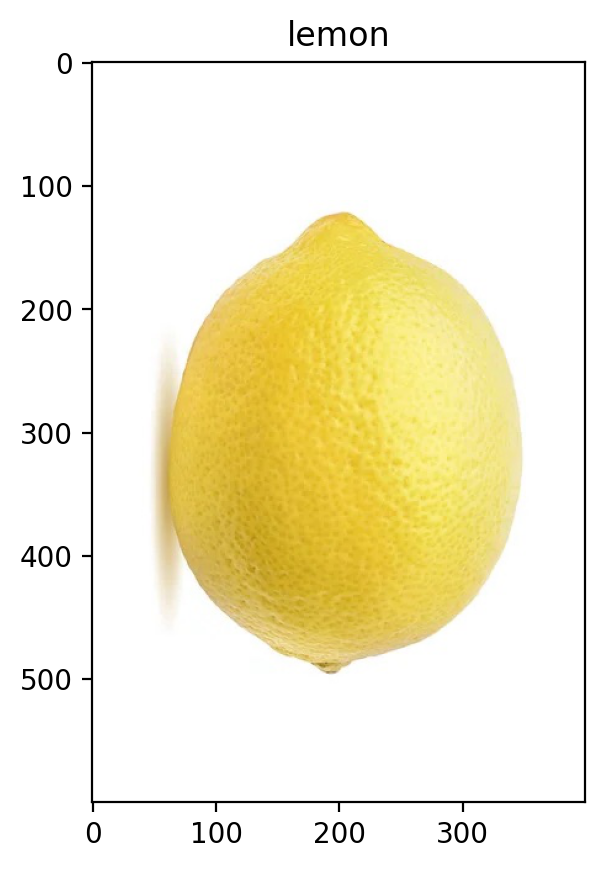

In [240]:
# plotting image from dataset
# test_img_path = val_dir+'Watermelon/255_100.jpg'
test_img_path = 'lemon02.jpg'
img = Image.open(test_img_path)
# lbl_origin = test_img_path.split('/')[2]
lbl_origin = 'lemon'
plt.title(lbl_origin)
plt.imshow(img);

### CNN
Now we need to create a network in order to train the model using the dataset

In [21]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.fc1 = nn.Linear(12 * 12 * 128, 512)
        self.relu11 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.5)

        self.fc2 = nn.Linear(512, 256)
        self.relu12 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.5)
        
        self.fc4 = nn.Linear(256, len(labels_list))
        
    
    def forward(self, x):
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.pool2(self.relu2(self.conv2(x)))
        x = self.pool3(self.relu3(self.conv3(x)))

        x = x.view(x.size(0), -1)
        # x = torch.flatten(x, 1)
        
        x = self.dropout1(self.relu11(self.fc1(x)))
        x = self.dropout2(self.relu12(self.fc2(x)))
        
        x = self.fc4(x)
        
        return x

In [22]:
model = CNN()
model

CNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu3): ReLU()
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=18432, out_features=512, bias=True)
  (relu11): ReLU()
  (dropout1): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (relu12): ReLU()
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc4): Linear(in_features=256, out_features=131, bias=True)
)

### Training Network
The next step is to train the network using the chosen architecture.

In [23]:
epochs = 5
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

running_loss = 0
train_losses = []
test_losses = []

# setting up gpu in tensorflow
with tf.device('/GPU:0'):
    for e in range(epochs):
        # training network
        model.train()
        for images, labels in train_loader:
            # zeroing out gradients
            optimizer.zero_grad()
            
            # forward pass
            output = model(images)
            loss = criterion(output, labels)

            running_loss += loss.item()

            # backwards and optmizing
            loss.backward()
            optimizer.step()

        else:
            # validating network
            test_loss = 0
            accuracy = 0
            total = 0
            correct = 0
            model.eval()
            with torch.no_grad():
                for images, labels in test_loader:
                    # forward pass
                    test_ps = model(images)
                    
                    t_loss = criterion(test_ps, labels)
                    test_loss += t_loss.item()
                    
                    # calculate accuracy
                    _, predicted = torch.max(test_ps.data, dim=1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()

            train_losses.append(running_loss/len(train_loader))
            test_losses.append(test_loss/len(test_loader))
            
            accuracy = 100 * correct / total

            print(f'epoch: {e+1}/{epochs}; '
                  f'running loss: {running_loss/len(train_loader):.3f}; '
                  f'test loss: {test_loss/len(test_loader):.3f}; '
                  f'accuracy: {accuracy:.3f}% ')
                  # f'accuracy: {accuracy/len(test_loader):.3f}; ')
            
            # resetting running loss
            running_loss = 0

epoch: 1/5; running loss: 1.873; test loss: 0.504; accuracy: 85.978% 
epoch: 2/5; running loss: 0.521; test loss: 0.264; accuracy: 92.511% 
epoch: 3/5; running loss: 0.323; test loss: 0.215; accuracy: 94.087% 
epoch: 4/5; running loss: 0.236; test loss: 0.174; accuracy: 95.373% 
epoch: 5/5; running loss: 0.192; test loss: 0.144; accuracy: 96.936% 


### Analyzing model training performance
Plotting the train and validation losses is a good way to gauge how well the model has performed

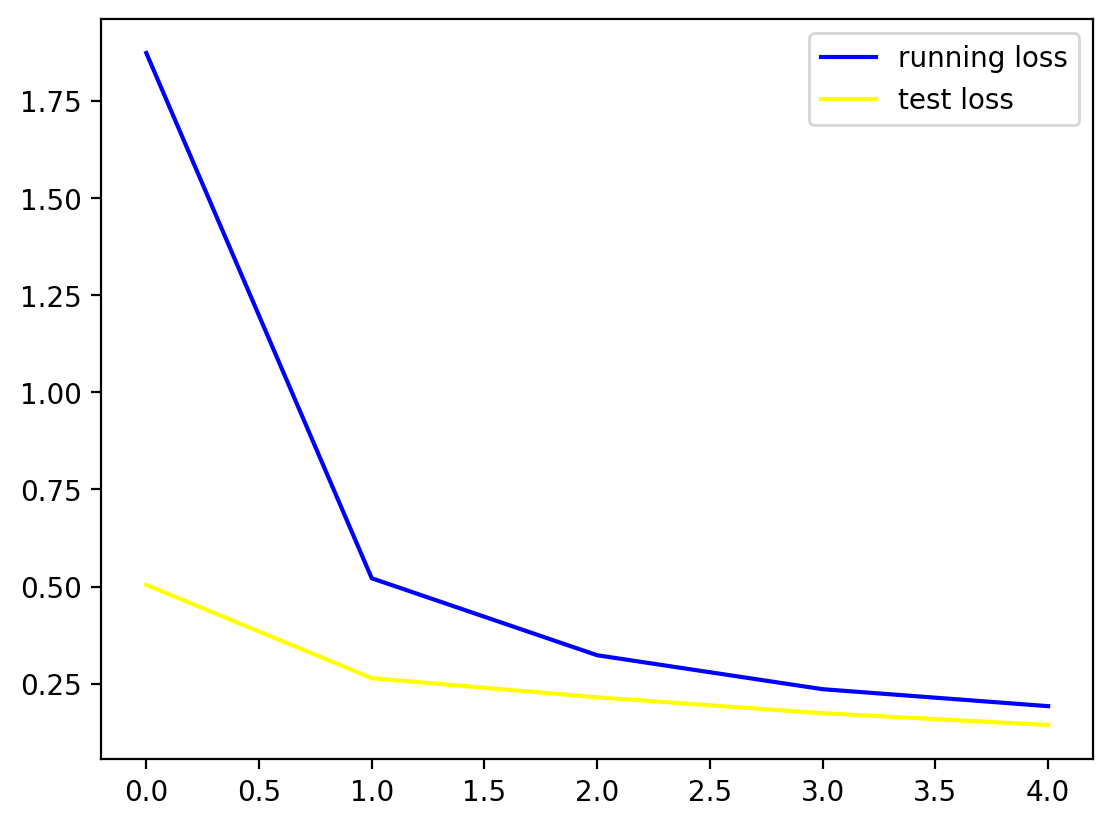

In [24]:
# plotting loss difference
fig, ax = plt.subplots()
ax.plot(train_losses, color = 'blue', label = 'running loss')
ax.plot(test_losses, color = 'yellow', label = 'test loss')
ax.legend()
plt.show()

### Processing and predicting image
Now that the CNN has been trained we can use the model to predict an image as input

In [102]:
# preprocess image before verifying
def preprocess_image(image_path):
    # image = transforms.ToPILImage()(image_path)
    image = Image.open(image_path)
    transform = transforms.Compose([
        transforms.Resize((100, 100)),
        transforms.ToTensor(),
        transforms.Normalize([0.5,0.5,0.5], 
                             [0.5,0.5,0.5])
    ])
    image = transform(image).unsqueeze(0)
    
    return image

In [189]:
# test the model using a random image
def predict(image_path):
    model.eval()
    with torch.no_grad():
        processed_image = preprocess_image(image_path)
        outputs = model(processed_image)
        # print(f'raw output tensor: {outputs}; tensor size: {len(outputs[0])}')
        
        topk_probs, topk_classes = torch.topk(F.softmax(outputs, dim=1), k=5)
        # print(f'topk probs: {topk_probs}')
        # print(f'topk classes: {topk_classes}')
        
    return topk_probs[0], topk_classes[0]

In [241]:
probs, preds = predict(test_img_path)
print(f'probabilities: {probs}')
print(f'predictions: {preds}')

probabilities: tensor([9.6543e-01, 1.9272e-02, 9.4211e-03, 5.3277e-03, 5.1462e-04])
predictions: tensor([88, 24, 98, 21, 91])


### Plotting prediction results
Finally, plotting the prediction output in order to put into perpective the results the model is processing using a random image from the dataset

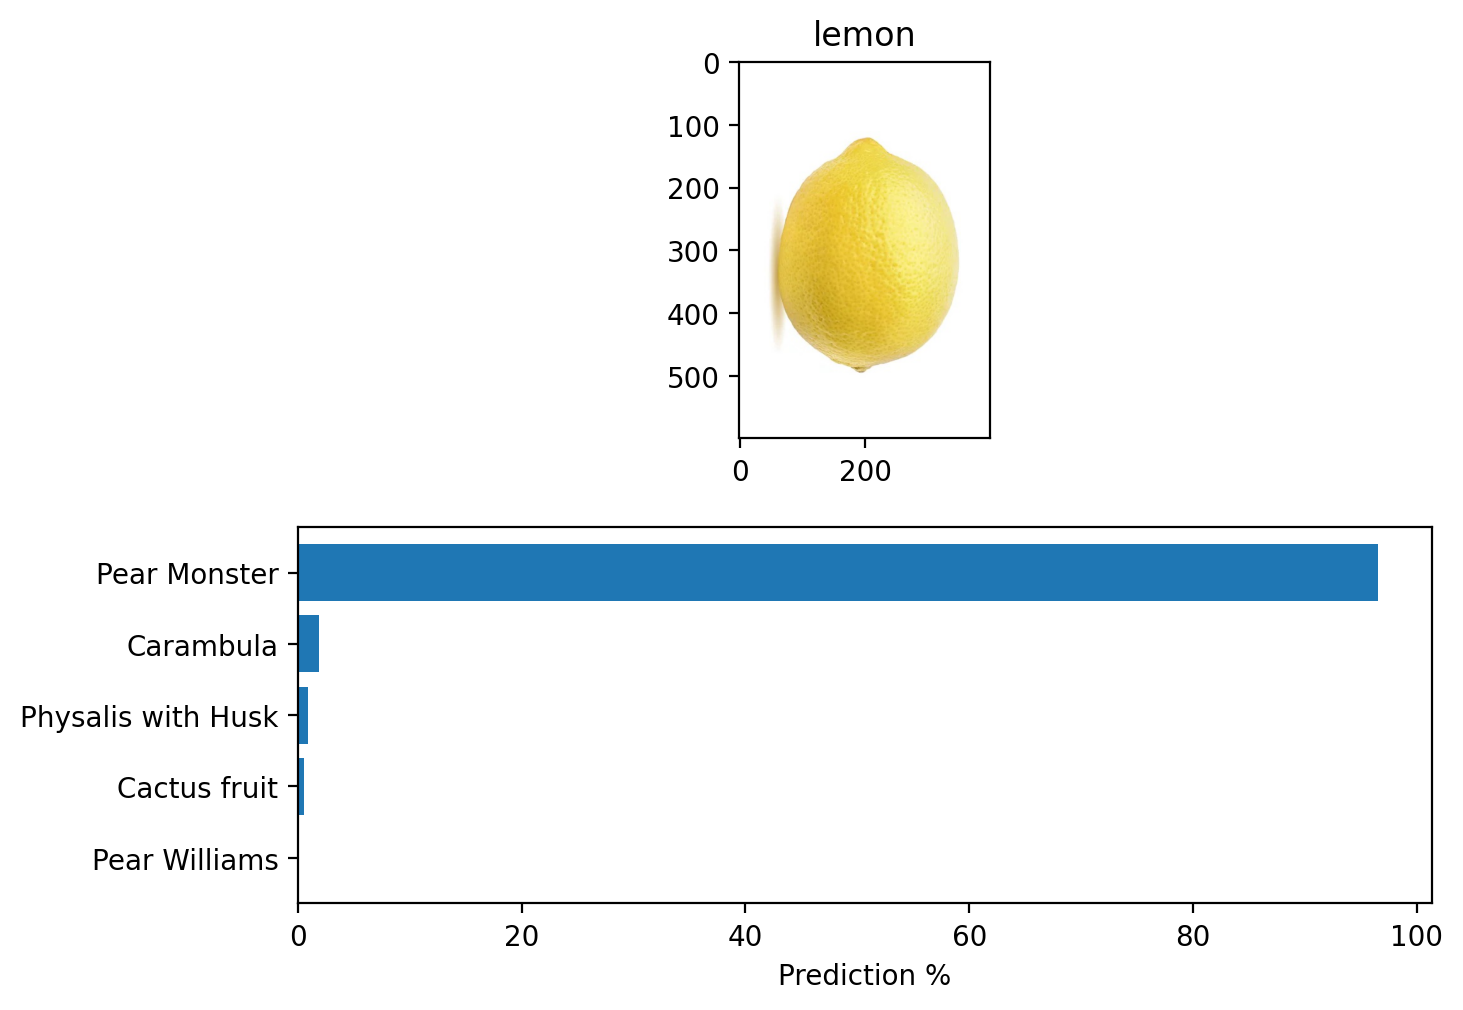

In [242]:
# plot image and chart of top k predicted values
fig, axs = plt.subplots(2)
fig.tight_layout()

axs[0].set_title(lbl_origin)
axs[0].imshow(img)

pred_labels = [labels_list[idx] for idx in preds]

y_pos = np.arange(len(probs))

# print(pred_labels)
prob_perc = [p * 100 for p in probs]
axs[1].barh(pred_labels, prob_perc)
axs[1].set_yticks(y_pos, labels=pred_labels)
axs[1].invert_yaxis()
axs[1].set_xlabel('Prediction %')
axs[1].plot();